In [ ]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nest_asyncio
import dateutil.parser
from datetime import datetime, timedelta
from dotenv import load_dotenv
import os
from cryptography.hazmat.primitives import serialization

# Import the provided client library
from clients.clients import KalshiHttpClient, Environment

# Plotting style
sns.set_theme(style="darkgrid")
%matplotlib inline

# --- CONFIGURATION ---
# Load your keys (Assumes you have a kalshi_key.txt or similar, or paste them here)
# NEVER share this notebook with your private keys hardcoded if you publish it.

# Initialize Client
try:
	nest_asyncio.apply()


	load_dotenv()
	env = Environment.PROD
	KEYID = os.getenv('KEYID')
	KEYFILE = os.getenv('KEYFILE')
	try:
		with open(KEYFILE, "rb") as key_file:
			private_key = serialization.load_pem_private_key(
				key_file.read(),
				password=None
			)
	except FileNotFoundError:
		raise FileNotFoundError(f"Private key file not found at {KEYFILE}")
	except Exception as e:
		raise Exception(f"Error loading private key: {str(e)}")

	client = KalshiHttpClient(
		key_id=KEYID,
		private_key=private_key,
		environment=env
	)
	print("✅ Client initialized successfully.")
except Exception as e:
	print(f"❌ Error initializing client: {e}")

✅ Client initialized successfully.


In [3]:

def fetch_market_candles(market_tickers, limit=1000):
    """Fetches and caches candlestick data to avoid repeated API calls."""
    out = []

    for i, ticker in enumerate(market_tickers):
        cache = []

        print(f"({i+1}/{len(market_tickers)}) Fetching market data for Series: {ticker}...")
        try:
            response = client.get_markets(
                series_ticker=ticker,
                status="settled",
                limit=limit
            )
        except Exception as e:
            print(f"❌ Failed to fetch markets for {ticker}: {e}")
            continue

        if 'markets' not in response:
            print(f"No markets found for {ticker}.")
            continue # Changed return [] to continue so other tickers process

        markets = response['markets']
        print(f"Found {len(markets)} markets. Fetching candle data...")

        for i, market in enumerate(markets):
            print(f"({i+1}/{len(markets)}) Market: {market['ticker']}")
            # A. Get Game Start Time
            end_ts = None
            for key in ['close_ts', 'expiration_ts', 'latest_expiration_ts', 'close_time']:
                if market.get(key):
                    val = market[key]
                    if isinstance(val, int):
                        end_ts = val
                        break
                    elif isinstance(val, str):
                        try:
                            # Ensure dateutil is imported
                            end_ts = int(dateutil.parser.parse(val).timestamp())
                            break
                        except Exception as e:
                            # print(f"Date parse error: {e}")
                            continue

            if end_ts is None:
                # print(f"Skipping market {market['ticker']} - No end timestamp found")
                continue

            # B. Define Window (48h Pre-Game)
            # Note: This logic assumes you want data ending 3 hours before close
            start_ts = end_ts - (60 * 60 * 3)

            try:
                resp = client.get_market_candlesticks(
                    series_ticker=ticker,
                    ticker=market['ticker'],
                    start_ts=start_ts,
                    end_ts=end_ts,
                    period_interval=1
                )

                candles = resp.get('candlesticks', [])

                # C. Filter Pre-Game Only
                if candles:
                    cache.append({
                        "ticker": market['ticker'],
                        "candles": candles
                    })
                # else:
                #     print(f"No candles returned for {market['ticker']}")

            except Exception as e:
                # Print the error instead of silently continuing
                print(f"❌ Error fetching candles for {market['ticker']}: {e}")
                continue

        out.append(cache)

    total_markets = sum(len(x) for x in out)
    print(f"Successfully cached data for {total_markets} markets from {len(out)} tickers.")
    return out

In [13]:
# Example usage
# data = fetch_market_candles(["KXNBAGAME", "KXNHLGAME", "KXMLBGAME", "KXNFLGAME"])
data = fetch_market_candles(["KXNBAGAME"], limit=1)
print(f"Returned {len(data)} items")

(1/1) Fetching market data for Series: KXNBAGAME...
Found 1 markets. Fetching candle data...
(1/1) Market: KXNBAGAME-25DEC03MIADAL-MIA
Successfully cached data for 1 markets from 1 tickers.
Returned 1 items


In [15]:
print(data)

[[{'ticker': 'KXNBAGAME-25DEC03MIADAL-MIA', 'candles': [{'end_period_ts': 1764810060, 'open_interest': 189057, 'price': {'close': 63, 'close_dollars': '0.6300', 'high': 63, 'high_dollars': '0.6300', 'low': 63, 'low_dollars': '0.6300', 'max': None, 'mean': 63, 'mean_dollars': '0.6300', 'min': None, 'open': 63, 'open_dollars': '0.6300', 'previous': 63, 'previous_dollars': '0.6300'}, 'volume': 91, 'yes_ask': {'close': 63, 'close_dollars': '0.6300', 'high': 64, 'high_dollars': '0.6400', 'low': 63, 'low_dollars': '0.6300', 'open': 63, 'open_dollars': '0.6300'}, 'yes_bid': {'close': 62, 'close_dollars': '0.6200', 'high': 62, 'high_dollars': '0.6200', 'low': 62, 'low_dollars': '0.6200', 'open': 62, 'open_dollars': '0.6200'}}, {'end_period_ts': 1764810120, 'open_interest': 189138, 'price': {'close': 63, 'close_dollars': '0.6300', 'high': 63, 'high_dollars': '0.6300', 'low': 63, 'low_dollars': '0.6300', 'max': None, 'mean': 63, 'mean_dollars': '0.6300', 'min': None, 'open': 63, 'open_dollars': 

In [6]:
def find_max_scalp_potential(market):
    ticker = market['ticker']
    max_price = 0
    open_price = market['candles'][0]['yes_ask']['close']
    for candle in market['candles'][1:]:
        yes_bid = candle.get('yes_bid')
        if yes_bid and yes_bid.get('high'):
            if yes_bid['high'] > max_price:
                max_price = yes_bid['high']

    profit_potential = max_price - open_price
    return {
        "ticker": ticker.split('-')[0],
        "market": ticker.split('-')[1],
	    "team":"".join(ticker.split('-')[2] + "-" + ticker.split('-')[0]),
        "open_price": open_price,
        "max_exit_price": max_price,
        "profit_potential": profit_potential,
        "win_5c": profit_potential >= 5,
        "win_10c": profit_potential >= 10
    }

In [14]:
tmp = []
for t in data:
	for j in t:
		tmp.append(find_max_scalp_potential(j))
df = pd.DataFrame(tmp)
df.head(6)

,ticker,market,team,open_price,max_exit_price,profit_potential,win_5c,win_10c
0,KXNBAGAME,25DEC03MIADAL,MIA-KXNBAGAME,63,74,11,True,True



==================== REPORT: AGGREGATE (All Tickers) ====================


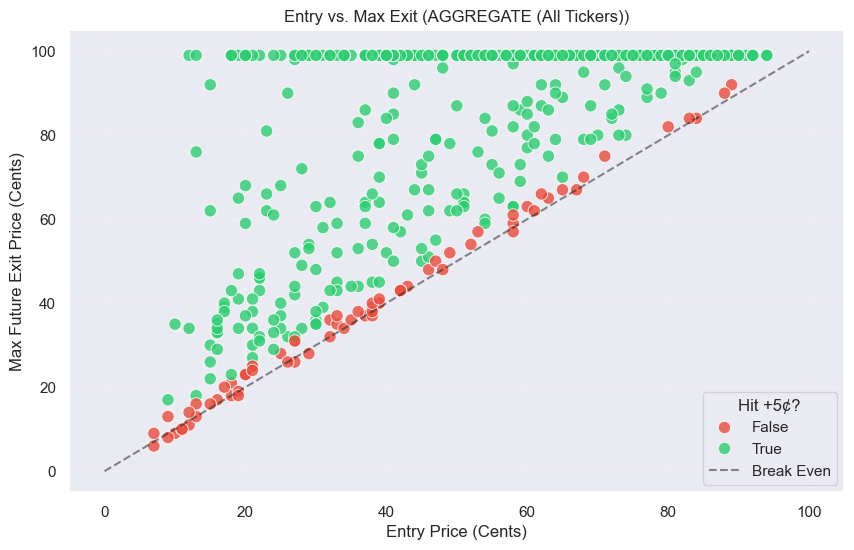

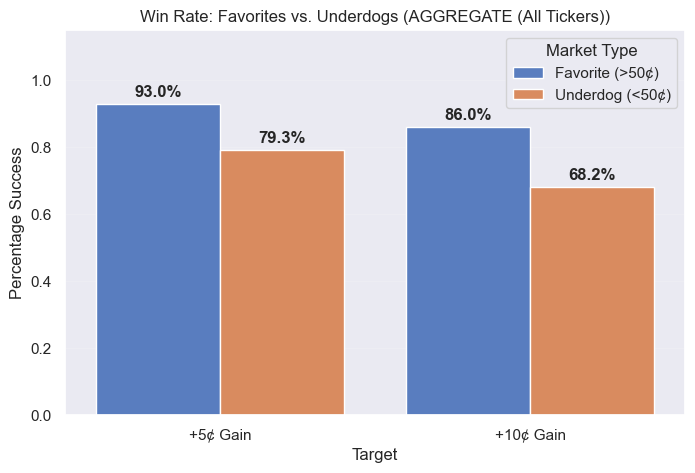

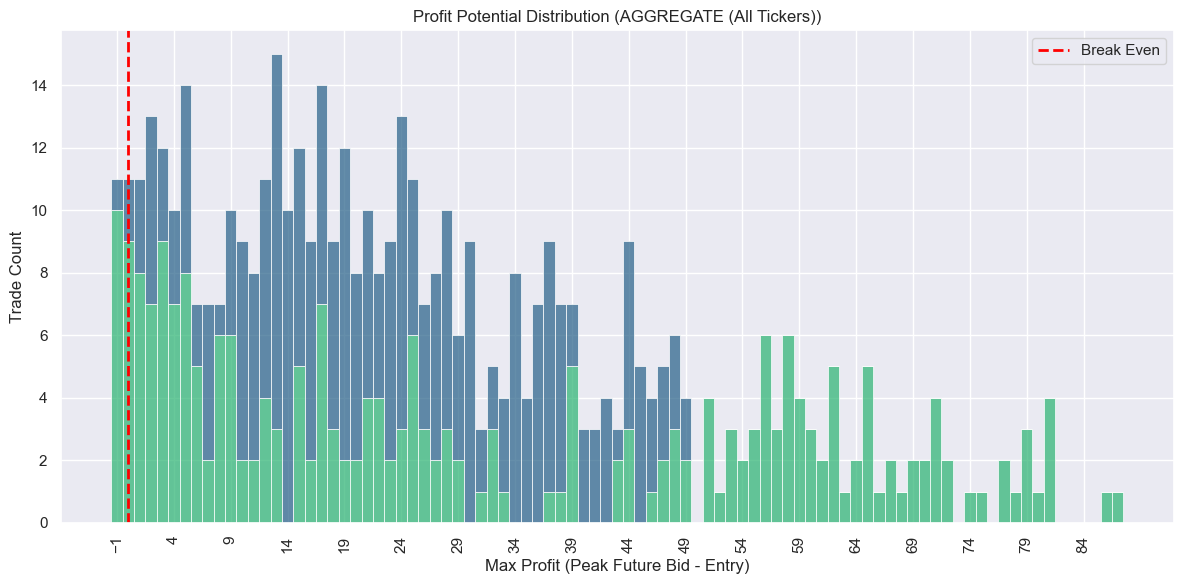

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

def generate_scalping_report(data, title_label):
    """
    Generates Scatter, Win Rate, and Distribution plots for a given dataframe.
    """
    if data.empty:
        print(f"Skipping {title_label}: No data available.")
        return

    # Ensure we are working with a copy
    df_plot = data.copy()

    # 1. Define Favorites vs Underdogs if not already present
    if 'type' not in df_plot.columns:
        df_plot['type'] = np.where(df_plot['open_price'] >= 50, 'Favorite (>50¢)', 'Underdog (<50¢)')

    print(f"\n{'='*20} REPORT: {title_label} {'='*20}")

    # -----------------------------
    # PLOT 1: SCATTER PLOT
    # -----------------------------
    plt.figure(figsize=(10, 6))
    sns.scatterplot(
        data=df_plot,
        x="open_price",
        y="max_exit_price",
        hue="win_5c",
        palette={True: "#2ecc71", False: "#e74c3c"},
        s=80,
        alpha=0.8
    )
    plt.plot([0, 100], [0, 100], 'k--', label="Break Even", alpha=0.5)

    plt.title(f"Entry vs. Max Exit ({title_label})")
    plt.xlabel("Entry Price (Cents)")
    plt.ylabel("Max Future Exit Price (Cents)")
    plt.legend(title="Hit +5¢?")
    plt.grid(True, alpha=0.15)
    plt.show()

    # -----------------------------
    # PLOT 2: WIN RATE BAR CHART
    # -----------------------------
    win_rates = df_plot.groupby('type')[['win_5c', 'win_10c']].mean().reset_index()

    if not win_rates.empty:
        win_rates = win_rates.melt(id_vars='type', var_name='Target', value_name='Win Rate')
        win_rates['Target'] = win_rates['Target'].replace({'win_5c': '+5¢ Gain', 'win_10c': '+10¢ Gain'})

        plt.figure(figsize=(8, 5))
        ax = sns.barplot(data=win_rates, x="Target", y="Win Rate", hue="type", palette="muted")

        plt.ylim(0, 1.15)
        plt.title(f"Win Rate: Favorites vs. Underdogs ({title_label})")
        plt.ylabel("Percentage Success")
        plt.grid(axis='y', alpha=0.15)

        # --- FIX: Changed fontWeight to fontweight ---
        for container in ax.containers:
            ax.bar_label(container, fmt='{:.1%}', padding=3, fontweight='bold')

        plt.legend(title="Market Type")
        plt.show()
    else:
        print(f"  > Not enough data to generate Win Rate chart for {title_label}")

    # -----------------------------
    # PLOT 3: DISTRIBUTION HISTOGRAM
    # -----------------------------
    plt.figure(figsize=(12, 6))

    min_val = int(df_plot['profit_potential'].min())
    max_val = int(df_plot['profit_potential'].max())

    sns.histplot(
        data=df_plot,
        x='profit_potential',
        discrete=True,
        hue='type',
        multiple="stack",
        palette="viridis",
        edgecolor="white",
        linewidth=0.5
    )

    plt.axvline(0, color='red', linestyle='--', label="Break Even", linewidth=2)
    plt.title(f"Profit Potential Distribution ({title_label})")
    plt.xlabel("Max Profit (Peak Future Bid - Entry)")
    plt.ylabel("Trade Count")

    # Logic to prevent overcrowded x-axis labels
    if max_val - min_val < 50:
        plt.xticks(np.arange(min_val, max_val + 1, 1), rotation=90)
    elif max_val - min_val < 100:
        plt.xticks(np.arange(min_val, max_val + 1, 5), rotation=90)

    plt.legend()
    plt.tight_layout()
    plt.show()


# ==========================================
# MAIN EXECUTION LOOP
# ==========================================

if not df.empty:
    # 1. Generate Aggregate Report
    generate_scalping_report(df, "AGGREGATE (All Tickers)")

    # 2. Generate Individual Reports
    unique_tickers = df['ticker'].unique()

    if len(unique_tickers) > 1:
        for ticker in unique_tickers:
            ticker_df = df[df['ticker'] == ticker]
            generate_scalping_report(ticker_df, f"Ticker: {ticker}")
else:
    print("DataFrame is empty. No plots generated.")

Paired 500 trades with their opponents.


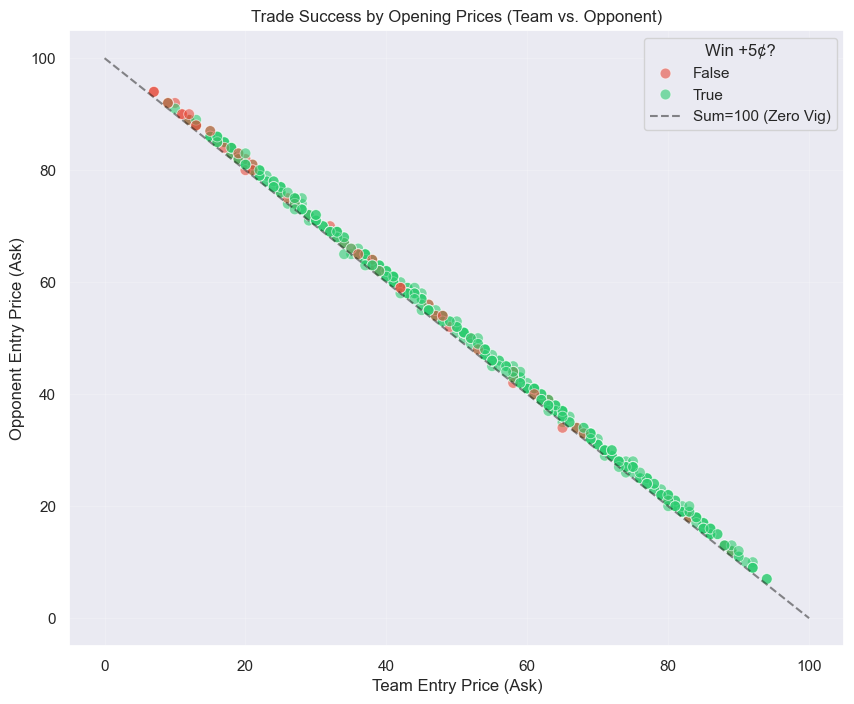

/var/folders/9r/tylbjppj1_92bdn7y4cqgr_w0000gn/T/ipykernel_9376/1333681492.py:110: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  win_rate_by_type = df_paired.groupby('match_type')['win_5c'].mean().reset_index()
/var/folders/9r/tylbjppj1_92bdn7y4cqgr_w0000gn/T/ipykernel_9376/1333681492.py:113: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=win_rate_by_type, x='match_type', y='win_5c', palette='viridis')


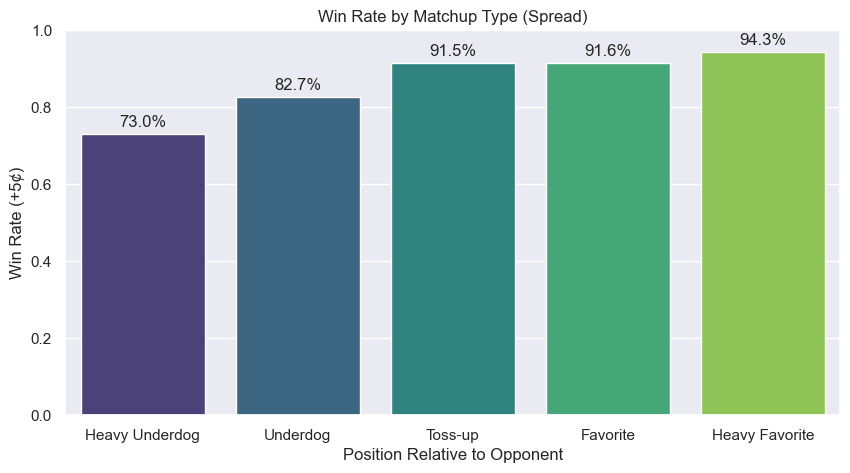

In [9]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# 1. Helper to parse Event ID and Prices
def get_market_metrics(market):
    ticker = market['ticker']
    parts = ticker.split('-')

    # Validation: Ensure ticker format is Series-Event-Team
    if len(parts) < 3: return None

    series_id = parts[0]      # e.g. KXNBAGAME
    event_id = parts[1]       # e.g. 25DEC01PHXLAL (The common link)
    team = parts[2]           # e.g. PHX

    candles = market.get('candles', [])
    if not candles or len(candles) < 2: return None

    # Entry: Ask Close of first candle
    # (Using Ask because that is the realistic buy price)
    entry_val = candles[0].get('yes_ask', {}).get('close', 0)

    # Filter dead/invalid markets
    if entry_val <= 0 or entry_val >= 100: return None

    # Exit: Bid High of subsequent candles
    future_highs = [c['yes_bid'].get('high', 0) for c in candles[1:]]
    if not future_highs: return None

    max_exit = max(future_highs)
    profit = max_exit - entry_val

    return {
        'ticker': ticker,
        'event_id': event_id,
        'team': team,
        'open_price': entry_val,
        'max_exit': max_exit,
        'profit': profit,
        'win_5c': profit >= 5
    }

# 2. Process all data
# Flatten the 'data' list (which is a list of lists)
all_markets = [m for sublist in data for m in sublist]
parsed_data = []

for m in all_markets:
    res = get_market_metrics(m)
    if res:
        parsed_data.append(res)

df_base = pd.DataFrame(parsed_data)

if not df_base.empty:
    # 3. Pair Opponents
    # Merge the dataframe with itself on 'event_id' to align opponents side-by-side
    df_merged = pd.merge(df_base, df_base, on='event_id', suffixes=('', '_opp'))

    # Filter out self-matches (Team A vs Team A)
    # We only want rows where I am 'team' and opponent is 'team_opp'
    df_paired = df_merged[df_merged['team'] != df_merged['team_opp']].copy()

    print(f"Paired {len(df_paired)} trades with their opponents.")

    # 4. Visualization
    plt.figure(figsize=(10, 8))

    # Scatter Plot: My Open vs Opponent Open
    # Green dots = Win, Red dots = Loss
    sns.scatterplot(
        data=df_paired,
        x='open_price',
        y='open_price_opp',
        hue='win_5c',
        palette={True: '#2ecc71', False: '#e74c3c'}, # Bright Green/Red
        alpha=0.6,
        s=60
    )

    # Add a reference line for "Perfect Efficiency" (Price A + Price B = 100)
    x_line = np.linspace(0, 100, 100)
    y_line = 100 - x_line
    plt.plot(x_line, y_line, 'k--', label='Sum=100 (Zero Vig)', alpha=0.5)

    plt.title("Trade Success by Opening Prices (Team vs. Opponent)")
    plt.xlabel("Team Entry Price (Ask)")
    plt.ylabel("Opponent Entry Price (Ask)")
    plt.legend(title="Win +5¢?")
    plt.grid(True, alpha=0.2)
    plt.show()

    # 5. Bar Chart: Win Rate by "Tightness" of Match
    # Define 'Spread' as abs(My Price - Opp Price)
    # Low spread = Tight game (e.g., 52 vs 48). High spread = Blowout (e.g., 80 vs 20).
    df_paired['price_spread'] = (df_paired['open_price'] - df_paired['open_price_opp'])

    # Bin the spread into categories
    # < -50: I am heavy underdog
    # -50 to -10: I am moderate underdog
    # -10 to 10: Toss-up
    # 10 to 50: I am moderate favorite
    # > 50: I am heavy favorite
    bins = [-100, -50, -10, 10, 50, 100]
    labels = ['Heavy Underdog', 'Underdog', 'Toss-up', 'Favorite', 'Heavy Favorite']
    df_paired['match_type'] = pd.cut(df_paired['price_spread'], bins=bins, labels=labels)

    win_rate_by_type = df_paired.groupby('match_type')['win_5c'].mean().reset_index()

    plt.figure(figsize=(10, 5))
    ax = sns.barplot(data=win_rate_by_type, x='match_type', y='win_5c', palette='viridis')

    plt.title("Win Rate by Matchup Type (Spread)")
    plt.xlabel("Position Relative to Opponent")
    plt.ylabel("Win Rate (+5¢)")
    plt.ylim(0, 1.0)

    for container in ax.containers:
        ax.bar_label(container, fmt='{:.1%}', padding=3)

    plt.show()

else:
    print("No paired data available.")

Analyzing 30 teams with at least 5 trades each.


/var/folders/9r/tylbjppj1_92bdn7y4cqgr_w0000gn/T/ipykernel_9376/225743212.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


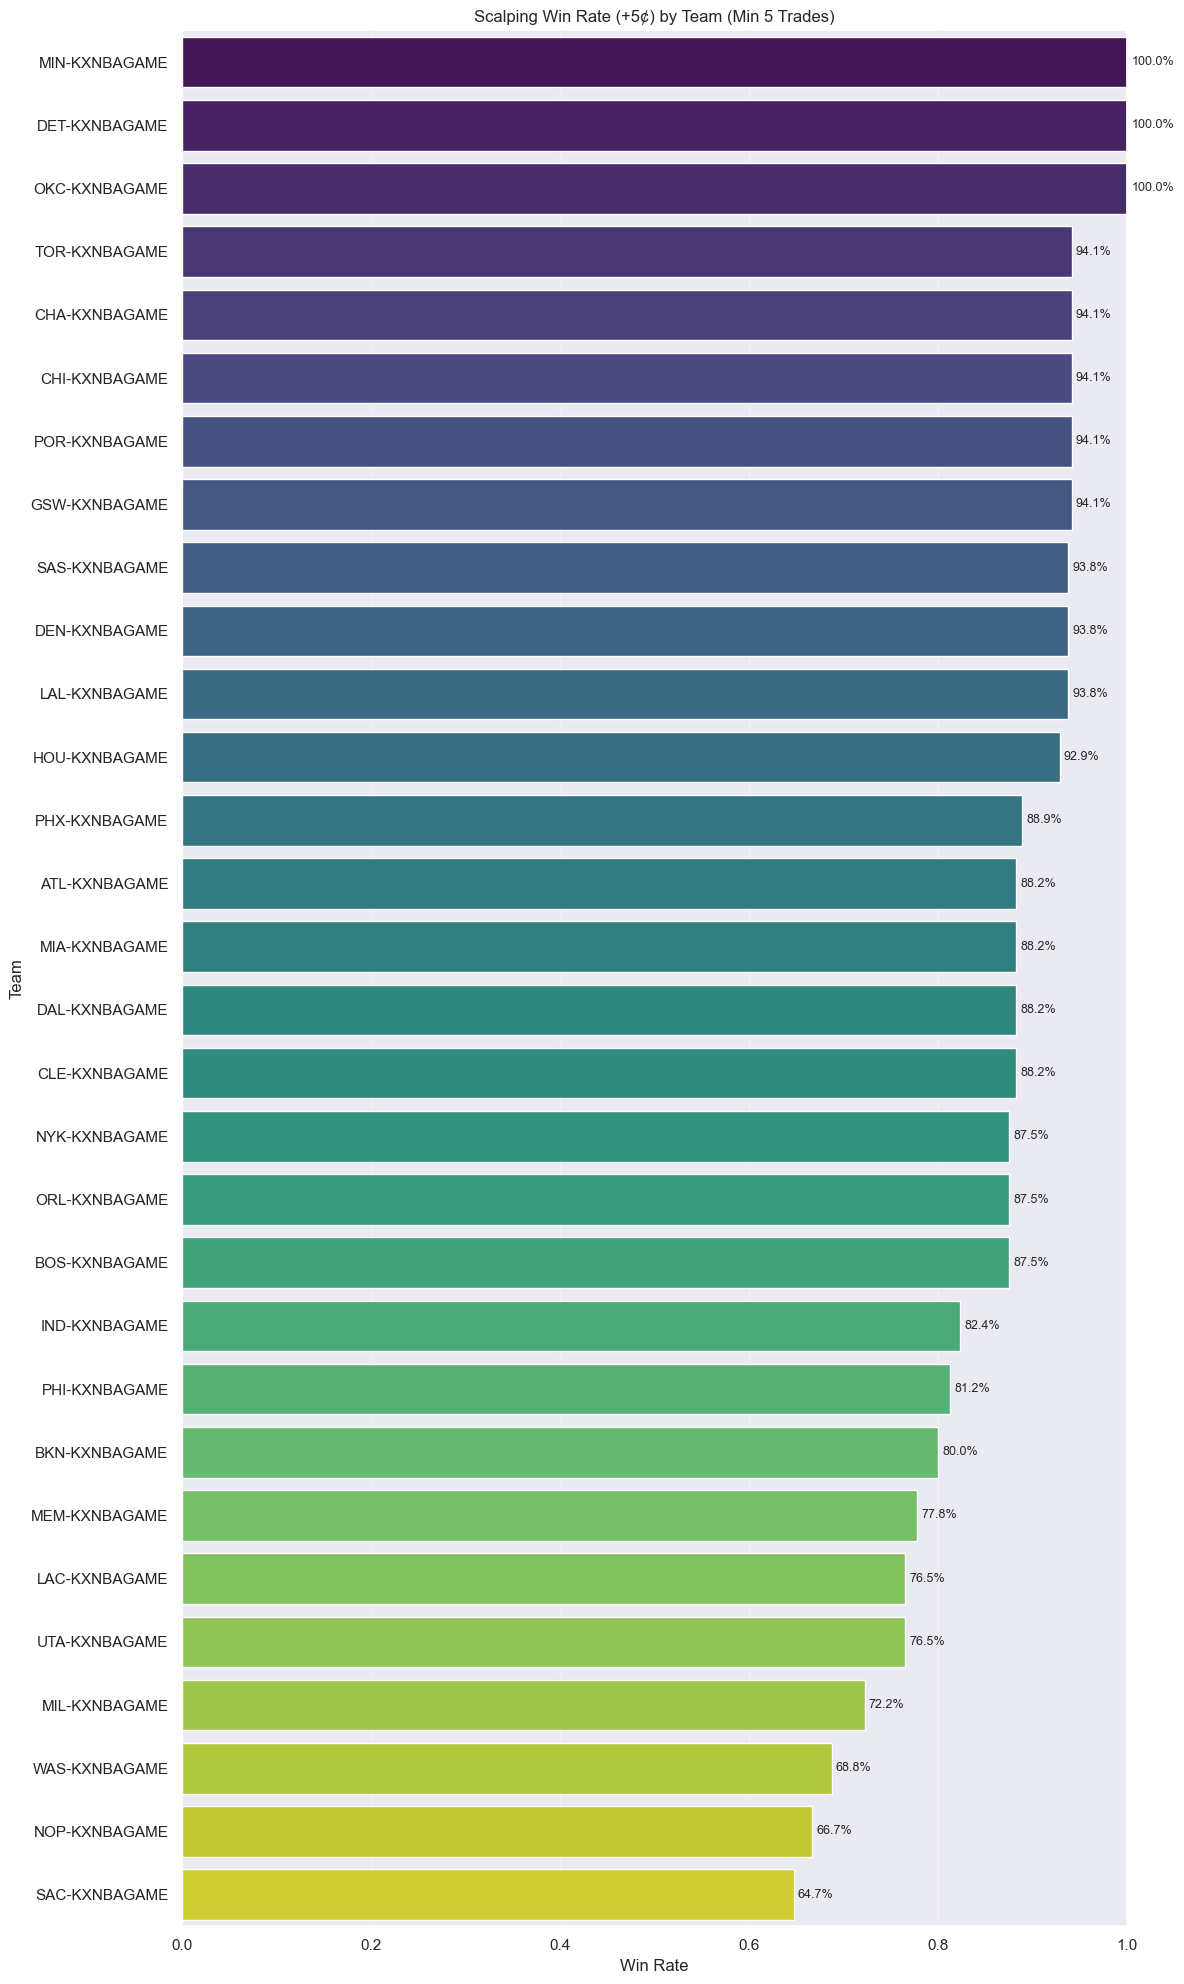

In [10]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def analyze_team_performance(df, min_trades=5):
    """
    Analyzes and graphs the win rate of scalping trades by team using the pre-processed DataFrame.

    Args:
        df (pd.DataFrame): DataFrame with columns ['ticker', 'market', 'team', ... 'win_5c']
        min_trades (int): Minimum number of trades required for a team to be included.
    """

    if df.empty:
        print("Input DataFrame is empty.")
        return

    # 1. Aggregate Data by Team
    # We can group directly by the existing 'team' column
    team_stats = df.groupby('team').agg(
        trades=('win_5c', 'count'),
        win_rate=('win_5c', 'mean')
    ).reset_index()

    # 2. Filter out teams with too few trades
    team_stats = team_stats[team_stats['trades'] >= min_trades]

    # 3. Sort by Win Rate for better visualization
    team_stats = team_stats.sort_values(by='win_rate', ascending=False)

    print(f"Analyzing {len(team_stats)} teams with at least {min_trades} trades each.")

    if team_stats.empty:
        print(f"No teams found with >= {min_trades} trades.")
        return

    # 4. Plotting
    plt.figure(figsize=(12, 20))

    ax = sns.barplot(
        data=team_stats,
        y='team',
        x='win_rate',
        palette='viridis'
    )

    # Styling
    plt.title(f"Scalping Win Rate (+5¢) by Team (Min {min_trades} Trades)")
    plt.xlabel("Win Rate")
    plt.ylabel("Team")
    plt.xlim(0, 1.0)
    plt.grid(axis='x', alpha=0.3)

    # Add percentage labels
    for container in ax.containers:
        ax.bar_label(container, fmt='{:.1%}', padding=3, fontsize=9)

    plt.tight_layout()
    plt.show()

# --- USAGE ---
analyze_team_performance(df, min_trades=5)

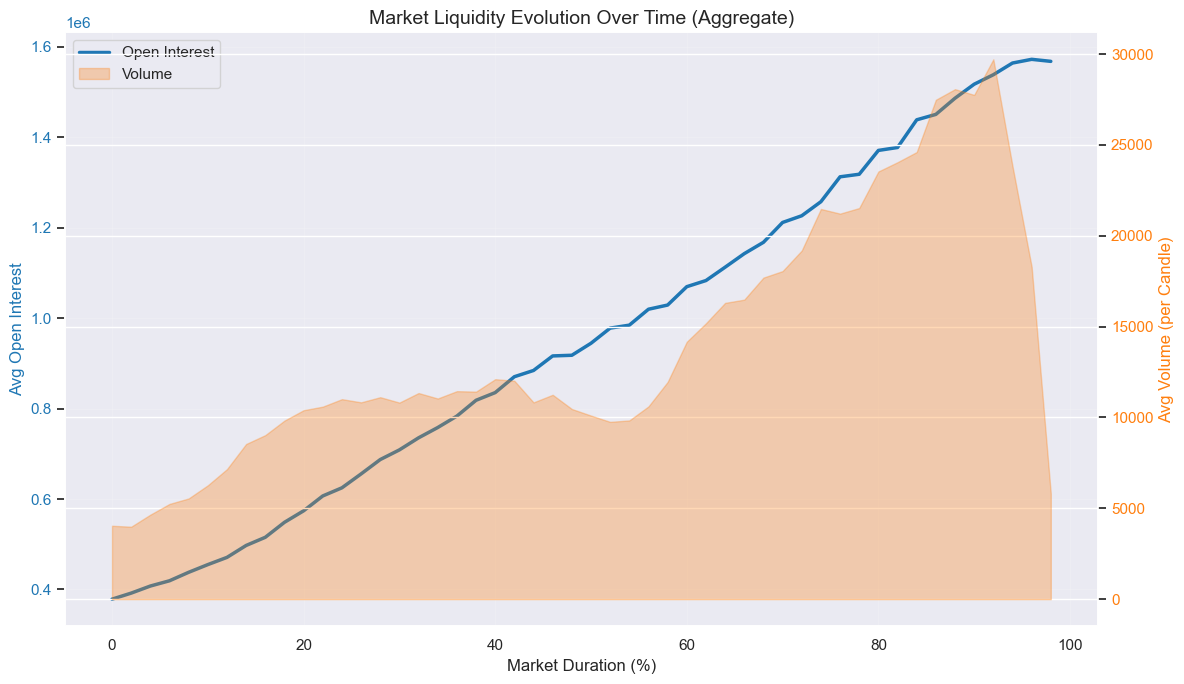

In [12]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def visualize_market_liquidity(data):
    """
    Visualizes market liquidity (volume and open interest) over the lifetime of the market.
    """

    # 1. Helper to extract time-series liquidity data
    def get_liquidity_data(market):
        ticker = market['ticker']
        candles = market.get('candles', [])

        if not candles or len(candles) < 10:  # Need enough data points for a meaningful timeline
            return None

        # Get start and end times to normalize the timeline
        start_ts = candles[0]['end_period_ts']
        end_ts = candles[-1]['end_period_ts']
        duration = end_ts - start_ts

        if duration <= 0:
            return None

        liquidity_points = []
        for candle in candles:
            current_ts = candle['end_period_ts']

            # Normalize time: 0.0 = Start, 1.0 = End of data
            normalized_time = (current_ts - start_ts) / duration

            # Volume and Open Interest
            volume = candle.get('volume', 0)
            open_interest = candle.get('open_interest', 0)

            liquidity_points.append({
                'ticker': ticker,
                'normalized_time': normalized_time,
                'volume': volume,
                'open_interest': open_interest
            })

        return liquidity_points

    # 2. Process all data
    # Flatten the data structure if it's nested
    all_markets = [m for sublist in data for m in sublist] if any(isinstance(i, list) for i in data) else data

    all_points = []
    for m in all_markets:
        points = get_liquidity_data(m)
        if points:
            all_points.extend(points)

    df_liquidity = pd.DataFrame(all_points)

    if df_liquidity.empty:
        print("No liquidity data available to plot.")
        return

    # 3. Bin the timeline for aggregation
    # We group data into 100 bins (percentage of market lifetime)
    df_liquidity['time_bin'] = pd.cut(df_liquidity['normalized_time'], bins=50, labels=False)

    # Calculate average liquidity per bin
    agg_liquidity = df_liquidity.groupby('time_bin').agg(
        avg_volume=('volume', 'mean'),
        avg_open_interest=('open_interest', 'mean')
    ).reset_index()

    # Convert bin to percentage for plotting
    agg_liquidity['progress_pct'] = (agg_liquidity['time_bin'] / 50) * 100

    # 4. Visualization
    fig, ax1 = plt.subplots(figsize=(12, 7))

    # Plot Open Interest (Line Chart)
    color = 'tab:blue'
    ax1.set_xlabel('Market Duration (%)')
    ax1.set_ylabel('Avg Open Interest', color=color, fontsize=12)
    sns.lineplot(
        data=agg_liquidity,
        x='progress_pct',
        y='avg_open_interest',
        ax=ax1,
        color=color,
        linewidth=2.5,
        label='Open Interest'
    )
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.grid(True, alpha=0.15)

    # Create twin axis for Volume
    ax2 = ax1.twinx()
    color = 'tab:orange'
    ax2.set_ylabel('Avg Volume (per Candle)', color=color, fontsize=12)

    # Plot Volume (Bar/Area Chart style) using fill_between for a smoother look
    # or barplot. Let's use barplot on top of the line.
    # Note: sns.barplot might misalign with continuous x-axis, so we use plt.bar or fill_between
    ax2.fill_between(
        agg_liquidity['progress_pct'],
        0,
        agg_liquidity['avg_volume'],
        color=color,
        alpha=0.3,
        label='Volume'
    )
    ax2.tick_params(axis='y', labelcolor=color)

    # Title and Layout
    plt.title("Market Liquidity Evolution Over Time (Aggregate)", fontsize=14)
    fig.tight_layout()

    # Manual Legend
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines + lines2, labels + labels2, loc='upper left')

    plt.show()

# --- RUN THE FUNCTION ---
visualize_market_liquidity(data)